[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shakilsustswe/Machine-Learning-Assignment/blob/master/Class%20Assignment/Normalization%20Using%20NN/House%20Rent%20Prediction%20Using%20Neural%20Network.ipynb)

**Problem statement**

The dataset comprises 5,863 JPEG X-Ray images and is categorised into two types (Pneumonia and Normal), organised into three folders: train, test, and val. Each folder contains subfolders for each image type.

These chest X-ray images (anterior-posterior view) were sourced from paediatric patients aged one to five years at a renowned hospital. The X-rays were part of the routine clinical care of these patients.

As a data scientist working in the healthcare industry, your task is to develop a convolutional neural network (CNN) model that can classify medical images into their respective categories. The model should be able to accurately identify the type of medical image shown in an image, based on the image itself.

Dataset: https://drive.google.com/file/d/1219EeGE1XTJVXYaulynJSa3BXGsbNCLx/view?usp=sharing

**Libraries**

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


**Drive Mount**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


**Dataset unzip and path defined**

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/x-ray_image.zip" -d "/content/drive/MyDrive/Colab Notebooks/x-ray_image"

**Dataset directory**

In [ ]:
img_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/", 'x-ray_image')


In [ ]:
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/x-ray_image"))

['val', 'test', '__MACOSX', 'train']


In [ ]:
data_dir=Path('/content/drive/MyDrive/Colab Notebooks/x-ray_image')
test_dir = data_dir/'test'
train_dir = data_dir/'train'
val_dir = data_dir/'val'
print(train_dir)
print(test_dir)
print(val_dir)

/content/drive/MyDrive/Colab Notebooks/x-ray_image/train
/content/drive/MyDrive/Colab Notebooks/x-ray_image/test
/content/drive/MyDrive/Colab Notebooks/x-ray_image/val


**Load Train Data**

In [ ]:
def load_train():
    normal_cases_dir=train_dir/'NORMAL'
    pneumonia_cases_dir = train_dir/'PNEUMONIA'
    # Get the list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    train_data=[]
    train_label=[]
    for img in normal_cases:
            train_data.append(img)
            train_label.append('NORMAL')
    for img in pneumonia_cases:
            train_data.append(img)
            train_label.append("PNEUMONIA")
    df=pd.DataFrame(train_data)
    df.columns=['images']
    df['labels']=train_label
    df=df.sample(frac=1).reset_index(drop=True)
    return df



In [ ]:
train_data=load_train()
train_data.shape


(5216, 2)

**Plot Train Data**

<BarContainer object of 2 artists>

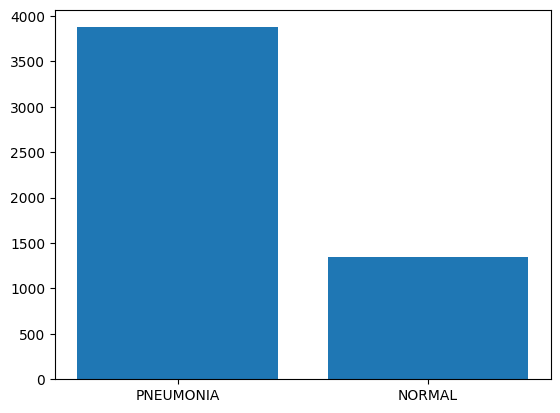

In [ ]:
plt.bar(train_data['labels'].value_counts().index,train_data['labels'].value_counts().values)

In [ ]:
tf.__version__

'2.15.0'

**Train Directory**

In [ ]:
os.listdir(train_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [ ]:

train_normal_dir = train_dir /"NORMAL"
train_pneumonia_dir = train_dir /"PNEUMONIA"

**Data Loading for Validation Dataset**

In [ ]:
os.listdir(val_dir)

['PNEUMONIA', 'NORMAL']

In [ ]:
valid_normal_dir = val_dir /"NORMAL"
valid_pneumonia_dir = val_dir /"PNEUMONIA"

**Data Loading for Test Dataset**

In [ ]:
os.listdir(test_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [ ]:
test_normal_dir = test_dir /"NORMAL"
test_pneumonia_dir = test_dir /"PNEUMONIA"

**Labeling**

Setting the dataset for training

In [ ]:
train_normal= train_normal_dir.glob("*.jpeg")
train_pneumonia=train_pneumonia_dir.glob("*.jpeg")
train_set=[]

In [ ]:
for img in train_normal:
  train_set.append((img, 0))
for img in train_pneumonia:
  train_set.append((img, 1))

In [ ]:
print(train_set[:5])

[(PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/train/NORMAL/IM-0327-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/train/NORMAL/IM-0529-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/train/NORMAL/IM-0425-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/train/NORMAL/IM-0464-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/train/NORMAL/IM-0575-0001.jpeg'), 0)]


In [ ]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)
train_set.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
1,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
2,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
3,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
4,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0


In [ ]:
#to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
train_set=train_set.sample(frac=1)
#to set the indexes as if first time
train_set=train_set.reset_index(drop=True)
train_set.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1
1,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1
2,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1
3,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
4,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1


Setting the dataset for valdiation

In [ ]:
#to take the normal images from validation set
valid_normal= valid_normal_dir.glob("*.jpeg")
#to take the pneumonia images from the validation set
valid_pneumonia=valid_pneumonia_dir.glob("*.jpeg")
#to add all the validation data into one list, we created a blank list
valid_set=[]

#to add every image of normals in validationset to the list
for img in valid_normal:
  valid_set.append((img, 0))#we add 0 with normal images as label

#to add every image of pneumonias in validationset to the list
for img in valid_pneumonia:
  valid_set.append((img, 1)) #we add 1 with pneumonia images as label

#to check what our list look like
print(valid_set[:5])

[(PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'), 0)]


In [ ]:
#to create a dataframe from the list, so that we can use dataframe features
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)
#to see the first 5 rows of our dataframe, only normals
valid_set.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
1,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
2,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
3,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
4,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0


In [ ]:
#to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
valid_set=valid_set.sample(frac=1)
 #to set the indexes as if first time

valid_set=valid_set.reset_index(drop=True)
valid_set.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
1,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
2,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1
3,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1
4,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0


Setting the dataset for test

In [ ]:
test_normal= test_normal_dir.glob("*.jpeg")
test_pneumonia=test_pneumonia_dir.glob("*.jpeg")
test_set=[]
for img in test_normal:
  test_set.append((img, 0))
for img in test_pneumonia:
  test_set.append((img, 1))
print(test_set[:5])

[(PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/test/NORMAL/IM-0039-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/test/NORMAL/NORMAL2-IM-0287-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/test/NORMAL/NORMAL2-IM-0105-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/test/NORMAL/IM-0021-0001.jpeg'), 0), (PosixPath('/content/drive/MyDrive/Colab Notebooks/x-ray_image/test/NORMAL/NORMAL2-IM-0073-0001.jpeg'), 0)]


In [ ]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)
test_set.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
1,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
2,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
3,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
4,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0


In [ ]:
test_set=test_set.sample(frac=1)
test_set=test_set.reset_index(drop=True)
test_set.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1
1,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
2,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1
3,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,0
4,/content/drive/MyDrive/Colab Notebooks/x-ray_i...,1


# Visualization

In [ ]:
# Normal Image
train_normal_count = train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [ ]:
print(train_normal_count)

1341


In [ ]:
# Pneumonia Image
train_pneumonia_count = train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


In [ ]:
print(train_pneumonia_count)

3875


In [ ]:
# plt.subplots(train_normal_count,train_pneumonia_count)
# plt.show()

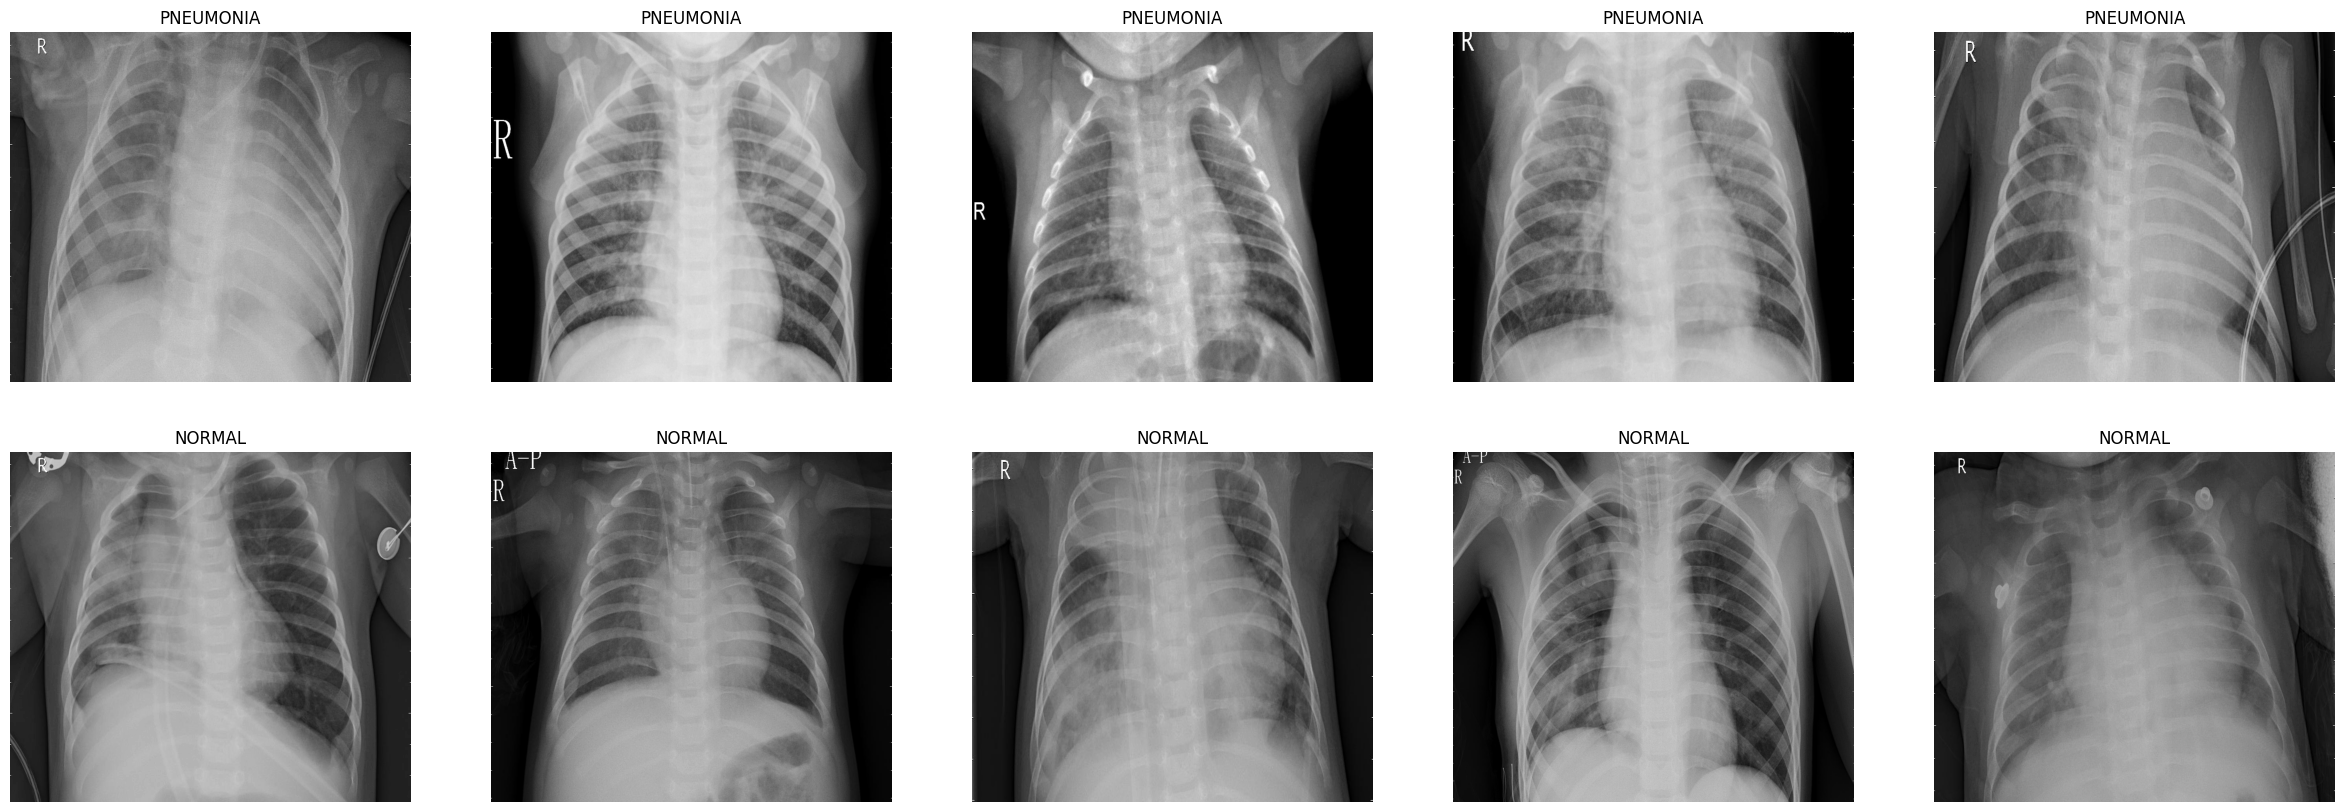

In [ ]:
from matplotlib.pyplot import imread
# Get few samples for both the classes
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:10]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:10]).tolist()

# Concate the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

In [ ]:
print(train_pneumonia_count)

3875


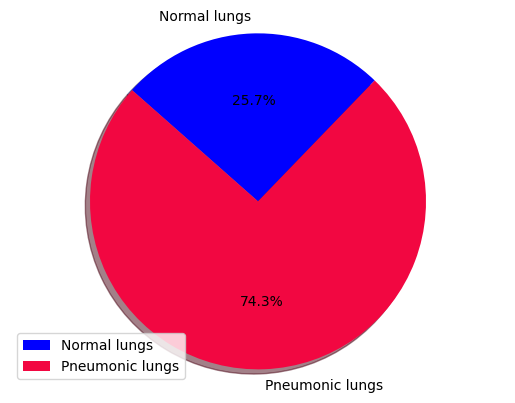

In [ ]:
fig1,ax1= plt.subplots()
sizes = [train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Normal lungs","Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b","#F20741"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

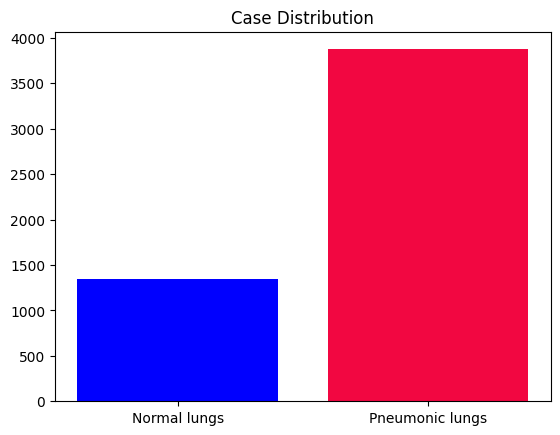

In [ ]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "#F20741"])
plt.title("Case Distribution")

# Data Preparation

**Data Distribution**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
#Get data
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

<ipython-input-98-0096977fee49>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
# initialize multiple lists
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

**Data Normalization**

In [ ]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

**Reshaping the data**

In [ ]:
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

**Data Augmentation**

Getting Train Generator


In [ ]:
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =20, #randomly rotate images in the range
  zoom_range = 0.1, #randomly zoom image
  width_shift_range = 0.2, #randomly shift images horizontally
  height_shift_range = 0.2, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images

image_generator.fit(X_train)

# DATA MODELLING

Building CNN Model

In [ ]:
from keras.layers import BatchNormalization,MaxPool2D

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 75, 75, 64)       

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
history = model.fit(image_generator.flow(X_train, y_train, batch_size=64), epochs=5, validation_data=image_generator.flow(X_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/5
92/92 [==============================] - 576s 6s/step - loss: 0.8830 - accuracy: 0.8171 - val_loss: 3.4410 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 2/5
92/92 [==============================] - 582s 6s/step - loss: 0.3163 - accuracy: 0.8827 - val_loss: 5.4568 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 3/5
92/92 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9028
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
92/92 [==============================] - 566s 6s/step - loss: 0.2554 - accuracy: 0.9028 - val_loss: 7.7980 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 4/5
92/92 [==============================] - 577s 6s/step - loss: 0.1898 - accuracy: 0.9320 - val_loss: 3.8457 - val_accuracy: 0.7297 - lr: 3.0000e-04
Epoch 5/5
92/92 [==============================] - 593s 6s/step - loss: 0.1786 - accuracy: 0.9343 - val_loss: 2.9373 - val_accuracy: 0.7298 - lr: 3.0000e-04


In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")


183/183 [==============================] - 126s 688ms/step - loss: 2.2025 - accuracy: 0.7304
Loss of the model is -  2.202501058578491
183/183 [==============================] - 118s 641ms/step - loss: 2.2025 - accuracy: 0.7304
Accuracy of the model is -  73.03619980812073 %


In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int")
predictions = predictions.reshape(1, -1)[0]
predictions[:5]

183/183 [==============================] - 114s 619ms/step


array([0, 0, 0, 0, 0])

In [ ]:
print(predictions)

[0 0 0 ... 0 0 0]


In [ ]:
import sklearn.metrics

print(sklearn.metrics.classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.73      1.00      0.84      4273
   Normal (Class 1)       1.00      0.00      0.01      1583

           accuracy                           0.73      5856
          macro avg       0.87      0.50      0.42      5856
       weighted avg       0.80      0.73      0.62      5856



In [ ]:
import sklearn.metrics
from sklearn.metrics import classification_report

# Assuming 'predictions' and 'y_test' are already defined
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.73      1.00      0.84      4273
   Normal (Class 1)       1.00      0.00      0.01      1583

           accuracy                           0.73      5856
          macro avg       0.87      0.50      0.42      5856
       weighted avg       0.80      0.73      0.62      5856



In [ ]:
cm = confusion_matrix(y_test, predictions)
cm

array([[4273,    0],
       [1579,    4]])

<Axes: >

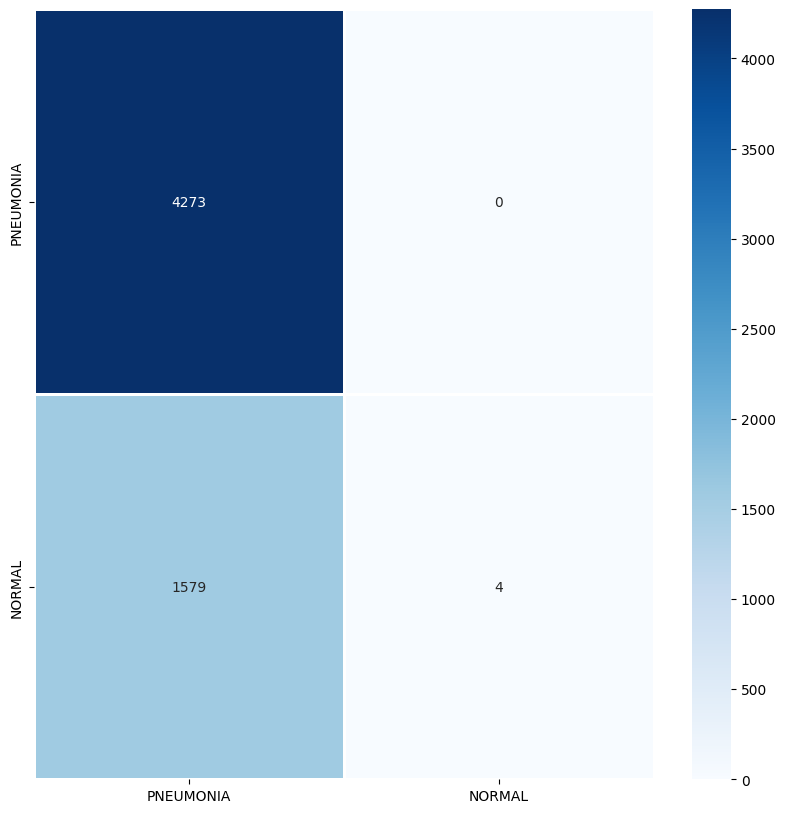

In [ ]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues" , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


# Reference

1) https://colab.research.google.com/drive/1hDyRJWJeixbGx425_R5f8tnuxf3w2by1

2) https://drive.google.com/file/d/1219EeGE1XTJVXYaulynJSa3BXGsbNCLx/view

3) https://www.kaggle.com/code/jonaspalucibarbosa/chest-x-ray-pneumonia-cnn-transfer-learning